In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

import os
from scipy.io import loadmat
import numpy as np
import tqdm
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
if tf.config.list_physical_devices('GPU'):
    print("Using GPU for Training")
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0],True)
else:
    print("Using CPU for Training")

Using GPU for Training


# On Original Data

In [3]:
import os
from scipy.io import loadmat

folder_path = 'data_classi/data_noaug/clean'
label_mapping = {"AS": 0, "MR": 1, "MVP": 2, "MS": 3, "N": 4}

# Function to extract label from file name
def extract_label(file_name):
    for key, value in label_mapping.items():
        if key in file_name:
            return value
    return None

# Lists to store data and labels
data_list = []
labels_list = []

# Loop through all files in the folder
for file_name in tqdm.tqdm(os.listdir(folder_path)):
    if file_name.endswith('.mat'):
        file_path = os.path.join(folder_path, file_name)

        # Load .mat file
        mat_data = loadmat(file_path)

        # Process your data as needed, for example, here just append the loaded data to the list
        data_list.append(mat_data)

        # Extract label from the file name
        label = extract_label(file_name)

        # Append the label to the labels list
        labels_list.append(label)

# Convert lists to arrays if needed
data_array = np.array(data_list)
labels_array = np.array(labels_list)

100%|██████████| 800/800 [00:00<00:00, 1750.60it/s]


In [4]:
denoise_spe_arrays = [entry['denoise_spe'] for entry in data_array]
# Find the maximum size along the second dimension
max_size = max(arr.shape[1] for arr in denoise_spe_arrays)
# Pad each array to have the same size
data_arrays = np.array([np.pad(arr, ((0, 0), (0, max_size - arr.shape[1])), mode='constant') for arr in denoise_spe_arrays])

In [5]:
data_arrays.shape,labels_array.shape

((800, 128, 512), (800,))

In [6]:
X_clean = data_arrays
y_clean = labels_array

In [7]:
X_clean.shape,y_clean.shape

((800, 128, 512), (800,))

In [8]:
# extract real part
X_clean_real  = np.real(X_clean)
X_clean_real.shape

(800, 128, 512)

In [9]:
np.count_nonzero(y_clean == 0), np.count_nonzero(y_clean == 1), np.count_nonzero(y_clean == 2),\
                np.count_nonzero(y_clean == 3),np.count_nonzero(y_clean == 4)

(160, 160, 160, 160, 160)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_clean_real, y_clean, test_size=0.20, random_state=42)

In [11]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((640, 128, 512), (160, 128, 512), (640,), (160,))

In [12]:
np.unique(y_valid, return_counts=True)[1]

array([32, 29, 34, 28, 37], dtype=int64)

In [13]:
np.expand_dims(X_train,axis=3)

array([[[[-1.81296490e+00],
         [-1.79386336e+00],
         [-1.39238525e+00],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],

        [[-1.71211290e-02],
         [ 5.75549758e-02],
         [-5.43631924e-01],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],

        [[ 9.36830452e-01],
         [ 6.68660208e-01],
         [ 1.92374684e+00],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],

        ...,

        [[-1.87574371e-04],
         [ 7.84955625e-04],
         [-1.07367147e-03],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],

        [[ 8.93696065e-04],
         [-2.25943256e-04],
         [-6.58919506e-04],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],

        [[ 1.09927251e-04],
         [-4.53707182e-04],
         [

In [14]:
# mport tensorflow as tf
# from tensorflow.keras import layers, models

# # Create the CNN model
# model = models.Sequential()

# # Convolutional Layer 1
# model.add(layers.Conv1D(32, kernel_size=33, strides=1, activation='relu', padding='same', input_shape=(128, 512)))
# model.add(layers.MaxPooling1D(pool_size=2, strides=1, padding='same'))
# model.add(layers.Dropout(0.5))

# # Convolutional Layer 2
# model.add(layers.Conv1D(16, kernel_size=13, strides=1, activation='relu', padding='same'))
# model.add(layers.MaxPooling1D(pool_size=2, strides=1, padding='same'))
# model.add(layers.Dropout(0.5))

# # Flatten layer
# model.add(layers.Flatten())

# # Reshape layer
# model.add(layers.Reshape((64, 32)))

# # GRU layer
# model.add(layers.GRU(64, return_sequences=False))  # Change to return_sequences=True
# model.add(layers.Dropout(0.5))

# # Bidirectional LSTM layer with input from GRU
# # model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=False)))
# # model.add(layers.Dropout(0.5))

# # Fully Connected Layer
# model.add(layers.Dense(5, activation='softmax'))

# # Display the model summary
# model.summary()

### Model

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Create the CNN model
model = models.Sequential()

# Reshape input to 2D
model.add(layers.Reshape((128, 512, 1), input_shape=(128, 512)))

# Convolutional Layer 1
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(layers.Dropout(0.5))

# Convolutional Layer 2
model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(layers.Dropout(0.5))

# Flatten layer
model.add(layers.Flatten())

# Reshape to apply GRU
model.add(layers.Reshape((32, 128 * 16)))  # 32 time steps, 128 * 16 features

# Apply GRU
model.add(layers.GRU(64, return_sequences=False))
model.add(layers.Dropout(0.5))

# Fully Connected Layer
model.add(layers.Dense(5, activation='softmax'))

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 512, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 512, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 256, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 256, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 256, 16)       4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 128, 16)      0         
 2D)                                                    

In [16]:
# # Define the model
# model = Sequential()

# # First Conv1D layer
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(128, 448)))
# model.add(MaxPooling1D(pool_size=2))

# # Second Conv1D layer
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))

# # Flatten layer to transition from convolutional layers to dense layers
# model.add(Flatten())

# # First Dense layer
# model.add(Dense(128, activation='relu'))

# # Second Dense layer
# model.add(Dense(64, activation='relu'))

# # Output layer with 5 units for the 5 classes and softmax activation
# model.add(Dense(5, activation='softmax'))

# model.summary()

In [17]:
# from sklearn.model_selection import KFold

# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# # Define the number of folds for cross-validation
# num_folds = 2
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# fold_counter = 1
# # Train the model using cross-validation
# for train_index, test_index in kf.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
    
#     print(f"Training Fold {fold_counter}")
#     model.fit(X_train, y_train, epochs=2, batch_size=64, validation_data=(X_test, y_test))
    
#     fold_counter += 1

In [18]:
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

initial_learning_rate = 0.0001  # Define your initial learning rate 0.0001  best
adam_optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model
model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
# early_stop = EarlyStopping(monitor='val_accuracy', patience=2)

# Train the model with early stopping
model.fit(np.expand_dims(X_train,axis=3), y_train, epochs=100, batch_size=64)

Epoch 1/100
10/10 [==============================] - 6s 56ms/step - loss: 1.6092 - accuracy: 0.2406
Epoch 2/100
10/10 [==============================] - 1s 54ms/step - loss: 1.6074 - accuracy: 0.3078
Epoch 3/100
10/10 [==============================] - 1s 55ms/step - loss: 1.6058 - accuracy: 0.3594
Epoch 4/100
10/10 [==============================] - 1s 54ms/step - loss: 1.6035 - accuracy: 0.3828
Epoch 5/100
10/10 [==============================] - 1s 58ms/step - loss: 1.6004 - accuracy: 0.4031
Epoch 6/100
10/10 [==============================] - 1s 54ms/step - loss: 1.5969 - accuracy: 0.3812
Epoch 7/100
10/10 [==============================] - 1s 54ms/step - loss: 1.5920 - accuracy: 0.4703
Epoch 8/100
10/10 [==============================] - 1s 54ms/step - loss: 1.5846 - accuracy: 0.4734
Epoch 9/100
10/10 [==============================] - 1s 54ms/step - loss: 1.5775 - accuracy: 0.4156
Epoch 10/100
10/10 [==============================] - 1s 54ms/step - loss: 1.5664 - accuracy: 0.5359

#### Prediction

In [19]:
pred = np.argmax(model.predict(X_valid),axis=1)
print(classification_report(y_valid,pred))

5/5 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       0.97      1.00      0.98        29
           2       0.97      0.91      0.94        34
           3       0.93      0.96      0.95        28
           4       1.00      1.00      1.00        37

    accuracy                           0.97       160
   macro avg       0.97      0.98      0.97       160
weighted avg       0.98      0.97      0.97       160



In [19]:
# # Assuming y_valid and pred are your true labels and predicted labels, respectively

# # Get the confusion matrix
# cm = confusion_matrix(y_valid, pred)

# # Define class labels
# class_labels = [0, 1, 2, 3, 4]

# plt.figure(figsize=(4,3)) 

# # Create a seaborn heatmap for visualization
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# # Add labels and title
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')

# # Display the plot
# plt.show()


In [20]:
# num_classes = cm.shape[0]

# for class_index in range(num_classes):
#     # True Positive for the current class
#     TP = cm[class_index, class_index]

#     # False Positive for the current class
#     FP = np.sum(cm[:, class_index]) - TP

#     # False Negative for the current class
#     FN = np.sum(cm[class_index, :]) - TP

#     print(f"False Positive for class {class_index}: {FP}")
#     print(f"False Negative for class {class_index}: {FN}")
#     print()

In [20]:
model.save("classi_model_gru.h5")

## Prediction on noisy data

In [47]:
import os
from scipy.io import loadmat

folder_path = 'data_classi/data_noaug/red5/noisy_Hristo'
label_mapping = {"AS": 0, "MR": 1, "MVP": 2, "MS": 3, "N": 4}

# Function to extract label from file name
def extract_label(file_name):
    for key, value in label_mapping.items():
        if key in file_name:
            return value
    return None

# Lists to store data and labels
data_list = []
labels_list = []

# Loop through all files in the folder
for file_name in tqdm.tqdm(os.listdir(folder_path)):
    if file_name.endswith('.mat'):
        file_path = os.path.join(folder_path, file_name)

        # Load .mat file
        mat_data = loadmat(file_path)

        # Process your data as needed, for example, here just append the loaded data to the list
        data_list.append(mat_data)

        # Extract label from the file name
        label = extract_label(file_name)

        # Append the label to the labels list
        labels_list.append(label)

# Convert lists to arrays if needed
data_noisy= np.array(data_list)
test_y_noisy= np.array(labels_list)



noise_spe_arrays = [entry['denoise_spe'] for entry in data_noisy]
max_size = 512
# max_size = max(arr.shape[1] for arr in noise_spe_arrays )
# Pad each array to have the same size
noisy_arrays = np.array([np.pad(arr, ((0, 0), (0, max_size - arr.shape[1])), mode='constant') for arr in noise_spe_arrays])

100%|██████████| 200/200 [00:02<00:00, 94.33it/s] 


In [48]:
test_X_noisy_real = np.real(noisy_arrays)

test_X_noisy_real.shape,test_y_noisy.shape

((200, 128, 512), (200,))

In [49]:
# #method1
# # Use the selected_indices to get the corresponding data from test_X_noisy_real and test_y
# test_X_noisy_subset = test_X_noisy_real[selected_indices]
# test_y_subset = test_y[selected_indices]

# # Display the selected data
# for i in range(len(selected_indices)):
#     index = selected_indices[i]
#     x_data = test_X_noisy_subset[i]
#     y_data = test_y_subset[i]
    
# test_X_noisy_subset.shape,test_y_subset.shape

In [50]:
# # Extract values from test_y using selected_indices
# test_y_subset = np.array([test_y[index] for index in selected_indices])

# # Extract corresponding entries from test_X_noisy_real using selected_indices
# test_X_noisy_subset = np.array([test_X_noisy_real[index] for index in selected_indices])

# # Checking the shapes of the subsets
# print("Shape of test_X_subset:", test_X_noisy_subset.shape)
# print("Shape of test_y_subset:", test_y_subset.shape)

In [51]:
pred = np.argmax(model.predict(test_X_noisy_real),axis=1)

In [52]:
print(classification_report(test_y_noisy,pred))

              precision    recall  f1-score   support

           0       0.73      0.47      0.58        40
           1       0.54      0.78      0.64        40
           2       0.50      0.82      0.62        40
           3       0.77      0.93      0.84        40
           4       1.00      0.07      0.14        40

    accuracy                           0.61       200
   macro avg       0.71      0.61      0.56       200
weighted avg       0.71      0.61      0.56       200



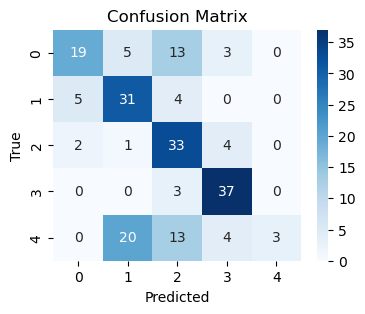

In [53]:
# Assuming test_y_subset and pred are your true labels and predicted labels, respectively

# Get the confusion matrix
cm = confusion_matrix(test_y_noisy, pred)

# Define class labels
class_labels = [0, 1, 2, 3, 4]

plt.figure(figsize=(4,3)) 

# Create a seaborn heatmap for visualization
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()


In [54]:
# num_classes = cm.shape[0]

# for class_index in range(num_classes):
#     # True Positive for the current class
#     TP = cm[class_index, class_index]

#     # False Positive for the current class
#     FP = np.sum(cm[:, class_index]) - TP

#     # False Negative for the current class
#     FN = np.sum(cm[class_index, :]) - TP

#     print(f"False Positive for class {class_index}: {FP}")
#     print(f"False Negative for class {class_index}: {FN}")
#     print()

# Denoise data

In [21]:
# from keras.models import load_model

# # Load the model from the file
# loaded_model = load_model("denoisy_unet_0db_wgn_100.h5")

In [20]:
import os
from scipy.io import loadmat

folder_path = 'data_classi/data_noaug/wgn-5/deoise_attnresi'
label_mapping = {"AS": 0, "MR": 1, "MVP": 2, "MS": 3, "N": 4}

# Function to extract label from file name
def extract_label(file_name):
    for key, value in label_mapping.items():
        if key in file_name:
            return value
    return None

# Lists to store data and labels
data_list = []
labels_list = []

# Loop through all files in the folder
for file_name in tqdm.tqdm(os.listdir(folder_path)):
    if file_name.endswith('.mat'):
        file_path = os.path.join(folder_path, file_name)

        # Load .mat file
        mat_data = loadmat(file_path)

        # Process your data as needed, for example, here just append the loaded data to the list
        data_list.append(mat_data)

        # Extract label from the file name
        label = extract_label(file_name)

        # Append the label to the labels list
        labels_list.append(label)

# Convert lists to arrays if needed
data_denoisy= np.array(data_list)
y_denoisy= np.array(labels_list)



denoise_spe_arrays = [entry['denoise_spe'] for entry in data_denoisy]
# max_size = max(arr.shape[1] for arr in denoise_spe_arrays )
max_size = 512
# Pad each array to have the same size
denoisy_arrays = np.array([np.pad(arr, ((0, 0), (0, max_size - arr.shape[1])), mode='constant') for arr in denoise_spe_arrays])

100%|██████████| 200/200 [00:00<00:00, 1838.91it/s]


In [21]:
test_X_denoisy_real = np.real(denoisy_arrays)

reshaped_array = test_X_denoisy_real[:, :128, :]
test_X_denoisy_real.shape,y_denoisy.shape,reshaped_array.shape

((200, 128, 512), (200,), (200, 128, 512))

## Gradcam

Existing layers are: ['reshape', 'conv2d', 'max_pooling2d', 'dropout', 'conv2d_1', 'max_pooling2d_1', 'dropout_1', 'flatten', 'reshape_1', 'gru', 'dropout_2', 'dense'].

In [35]:
pred = np.argmax(model.predict(reshaped_array),axis=1)
print(classification_report(y_denoisy,pred))

7/7 [==============================] - 0s 61ms/step
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        40
           1       0.63      0.78      0.70        40
           2       0.77      0.57      0.66        40
           3       0.86      0.93      0.89        40
           4       0.97      0.93      0.95        40

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.77       200
weighted avg       0.78      0.78      0.77       200



In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming y_denoisy contains true labels and pred contains predicted labels
# Calculate precision, recall, and F1-score
precision = precision_score(y_denoisy, pred, average='weighted')
recall = recall_score(y_denoisy, pred, average='weighted')
f1 = f1_score(y_denoisy, pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Precision: 0.7816938109393083
Recall: 0.775
F1-score: 0.7738112568808387


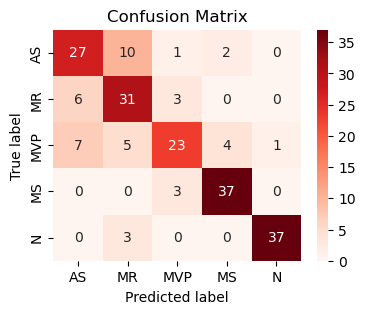

In [37]:
# Assuming test_y_subset and pred are your true labels and predicted labels, respectively

# Get the confusion matrix
cm = confusion_matrix(y_denoisy, pred)

# Define class labels
class_labels = ['AS', 'MR', 'MVP', 'MS', 'N']

plt.figure(figsize=(4,3)) 

# Create a seaborn heatmap for visualization
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()


In [207]:
import scipy.io
# Save the variable in .mat format
scipy.io.savemat('y_denoisy.mat', {'y_denoisy': y_denoisy})

In [208]:
scipy.io.savemat('pred.mat', {'pred': pred})

In [209]:
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 3, 2, 2, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 1, 4, 4,
       4, 4], dtype=int64)

In [31]:

# num_classes = cm.shape[0]

# for class_index in range(num_classes):
#     # True Positive for the current class
#     TP = cm[class_index, class_index]

#     # False Positive for the current class
#     FP = np.sum(cm[:, class_index]) - TP

#     # False Negative for the current class
#     FN = np.sum(cm[class_index, :]) - TP

#     print(f"False Positive for class {class_index}: {FP}")
#     print(f"False Negative for class {class_index}: {FN}")
#     print()